# 버스 내 승객 행동 예측하기

In [1]:
# 모듈로드
import json
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sql_setting import *
from sql_connect import Connect_DB
from collections import Counter

In [2]:
# json파일을 데프로 만들기 함수
# 알파벳은 각각의 카메라를 의미
action_str=['stand','walk','run','sit down','lay down','grab handle','kick','punch']
get_str=['get_off','get_on','nothing']
labelfold='../data/label/'

def json_df_make(fold):
    accident_df=pd.DataFrame()
    folder_li=[]
    json_name_li=[]
    action_int=[]
    get_int=[]

    for f in fold:
        path=labelfold+f
        for si_fo in os.listdir(path):
            files=path+si_fo+'/'
            for file in os.listdir(files):
                accident_dic=json.load(open(files+file))
                accident_dic_ann=accident_dic['annotations']
                if len(accident_dic_ann)!=0:
                    for i in range(len(accident_dic_ann)):
                        # 폴더명(카메라)
                        folder_li.append(f.split('/')[0])

                        # 파일명
                        json_name_li.append(file)

                        # 액션
                        if accident_dic_ann[i]['action']=='stand':
                            action_int.append(0)
                        elif accident_dic_ann[i]['action']=='walk':
                            action_int.append(1)
                        elif accident_dic_ann[i]['action']=='run':
                            action_int.append(2)
                        elif accident_dic_ann[i]['action']=='sit down':
                            action_int.append(3)
                        elif accident_dic_ann[i]['action']=='lay down':
                            action_int.append(4)
                        elif accident_dic_ann[i]['action']=='grab handle':
                            action_int.append(5)
                        elif accident_dic_ann[i]['action']=='kick':
                            action_int.append(6)
                        else:
                            action_int.append(7)
                        
                        # 승하차
                        if ((accident_dic_ann[i]['get_on']==False) & (accident_dic_ann[i]['get_off']==False)):
                            get_int.append(2)
                        elif accident_dic_ann[i]['get_on']==True:
                            get_int.append(1)
                        elif accident_dic_ann[i]['get_off']==True:
                            get_int.append(0)
                        else:
                            get_int.append(4)
                accident_df=pd.concat([accident_df,pd.DataFrame(accident_dic_ann)],ignore_index=True)

    accident_df['foldname']=folder_li # 카메라의 알파벳을 새로운 열로 추가
    accident_df['json_name']=json_name_li
    accident_df['action_int']=action_int
    accident_df['get_int']=get_int

    # boolean값 인수형으로 바꾸기
    accident_df.occluded=[1 if b==True else 0 for b in accident_df.occluded]
    accident_df.disabled=[1 if b==True else 0 for b in accident_df.disabled]
    accident_df['mask']=[1 if b==True else 0 for b in accident_df['mask']]

    # 필요없는 열 삭제
    accident_df=accident_df.drop(['get_on','get_off'],axis=1)

    return accident_df

### SQL연결

In [3]:
# 객체 생성
sql_con=Connect_DB()

In [4]:
# sql에 있는 전체 테이블 이름 출력
sql_con.get_table_names()

['action_dect_df', 'get_on_off_all']

In [7]:
# db와 연결한 테이블 불러옴
action_dect_df=sql_con.load_DB('action_dect_df')
action_dect_df

,id,bbox,occluded,num_keypoints,keypoints,action,age,disabled,mask,foldname,json_name,action_int,get_int
0,0,"[681, 436, 1470, 1075]",1,16,"[821, 1075, 0, 740, 986, 1, 979, 1014, 2, 1292...",sit down,adult,0,0,A,[emergency]accident07_001A_0.json,3,2
1,1,"[891, 147, 1007, 554]",1,16,"[945, 515, 2, 936, 433, 2, 933, 344, 2, 973, 3...",stand,adult,0,0,A,[emergency]accident07_001A_0.json,0,2
2,1,"[891, 147, 1007, 554]",1,16,"[945, 515, 2, 936, 433, 2, 933, 344, 2, 973, 3...",stand,adult,0,0,A,[emergency]accident07_001A_10.json,0,2
3,0,"[681, 420, 1470, 1075]",1,16,"[821, 1075, 0, 740, 983, 1, 979, 1012, 2, 1292...",sit down,adult,0,0,A,[emergency]accident07_001A_10.json,3,2
4,1,"[711, 162, 1026, 1034]",1,16,"[814, 1024, 1, 842, 844, 1, 831, 665, 2, 921, ...",walk,adult,0,0,A,[emergency]accident07_001A_100.json,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43901,1,"[611, 747, 1188, 1077]",1,16,"[997, 1077, 0, 997, 1010, 0, 1016, 1042, 0, 88...",walk,adult,0,0,H,[emergency]violence06_036H_550.json,1,2
43902,1,"[1189, 319, 1581, 720]",1,16,"[1458, 636, 1, 1483, 581, 1, 1494, 658, 1, 141...",sit down,adult,0,0,H,[emergency]violence06_036H_60.json,3,2
43903,1,"[1177, 288, 1569, 716]",1,16,"[1446, 632, 1, 1471, 577, 1, 1482, 654, 1, 139...",sit down,adult,0,0,H,[emergency]violence06_036H_70.json,3,2
43904,1,"[1163, 250, 1488, 716]",1,16,"[1373, 670, 1, 1372, 585, 1, 1418, 523, 2, 133...",stand,adult,0,0,H,[emergency]violence06_036H_80.json,0,2


In [8]:
# db와 연결한 테이블 불러옴
get_on_off_all_df=sql_con.load_DB('get_on_off_all')
get_on_off_all_df

,bbox,keypoints,action,get,action_num
0,"[585, 306, 805, 588]","[791, 578, 1, 785, 467, 2, 705, 534, 1, 636, 5...",sit down,2,3
1,"[570, 328, 805, 588]","[791, 578, 1, 785, 467, 2, 701, 539, 1, 639, 5...",sit down,2,3
2,"[611, 314, 808, 588]","[794, 573, 1, 778, 468, 1, 718, 559, 1, 651, 5...",sit down,2,3
3,"[611, 314, 808, 588]","[794, 573, 1, 778, 468, 1, 718, 559, 1, 651, 5...",sit down,2,3
4,"[615, 323, 808, 588]","[794, 573, 1, 778, 468, 1, 718, 559, 1, 651, 5...",sit down,2,3
...,...,...,...,...,...
458805,"[790, 177, 1523, 954]","[1054, 923, 1, 1050, 845, 1, 1046, 758, 2, 936...",grab handle,0,5
458806,"[780, 193, 1523, 954]","[1054, 923, 1, 1050, 845, 1, 1046, 758, 1, 923...",grab handle,0,5
458807,"[780, 193, 1523, 954]","[1054, 923, 1, 1024, 826, 1, 1020, 736, 1, 909...",grab handle,0,5
458808,"[771, 193, 1523, 923]","[1030, 889, 1, 1006, 799, 1, 1010, 714, 1, 903...",grab handle,0,5


- bbox와 keypoints의 타입은 문자열

#### 행동감지 데이터

In [12]:
# 라벨 개수 확인(action)
print(f"행동정수\n{Counter(action_dect_df.action_int)}")
print(f"행동문자\n{Counter(action_dect_df.action)}")

# 라벨 개수 확인(get_on_off)
print(f"승하차정수\n{Counter(action_dect_df.get_int)}")

행동정수
Counter({3: 14756, 0: 9412, 1: 8111, 4: 4718, 5: 3791, 7: 2641, 6: 327, 2: 150})
행동문자
Counter({'sit down': 14756, 'stand': 9412, 'walk': 8111, 'lay down': 4718, 'grab handle': 3791, 'punch': 2641, 'kick': 327, 'run': 150})
승하차정수
Counter({2: 43639, 1: 139, 0: 128})


#### 승하차 데이터

In [11]:
# 라벨 개수 확인(action)
print(f"행동정수\n{Counter(get_on_off_all_df.action_num)}")
print(f"행동문자\n{Counter(get_on_off_all_df.action)}")

# 라벨 개수 확인(get)
print(f"승하차정수\n{Counter(get_on_off_all_df['get'])}")

행동정수
Counter({3: 244818, 1: 128760, 5: 43866, 0: 40432, 2: 889, 4: 44, 6: 1})
행동문자
Counter({'sit down': 244818, 'walk': 128760, 'grab handle': 43866, 'stand': 40432, 'run': 889, 'lay down': 44, 'kick': 1})
승하차정수
Counter({2: 291335, 0: 111909, 1: 55566})


### csv파일 불러오기

In [13]:
action_dect_df=pd.read_csv('action_dect_df.csv',encoding='cp949')
action_dect_df

,id,bbox,occluded,num_keypoints,keypoints,action,age,disabled,mask,foldname,json_name,action_int,get_int
0,0,"[681, 436, 1470, 1075]",1,16,"[821, 1075, 0, 740, 986, 1, 979, 1014, 2, 1292...",sit down,adult,0,0,A,[emergency]accident07_001A_0.json,3,2
1,1,"[891, 147, 1007, 554]",1,16,"[945, 515, 2, 936, 433, 2, 933, 344, 2, 973, 3...",stand,adult,0,0,A,[emergency]accident07_001A_0.json,0,2
2,1,"[891, 147, 1007, 554]",1,16,"[945, 515, 2, 936, 433, 2, 933, 344, 2, 973, 3...",stand,adult,0,0,A,[emergency]accident07_001A_10.json,0,2
3,0,"[681, 420, 1470, 1075]",1,16,"[821, 1075, 0, 740, 983, 1, 979, 1012, 2, 1292...",sit down,adult,0,0,A,[emergency]accident07_001A_10.json,3,2
4,1,"[711, 162, 1026, 1034]",1,16,"[814, 1024, 1, 842, 844, 1, 831, 665, 2, 921, ...",walk,adult,0,0,A,[emergency]accident07_001A_100.json,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43901,1,"[611, 747, 1188, 1077]",1,16,"[997, 1077, 0, 997, 1010, 0, 1016, 1042, 0, 88...",walk,adult,0,0,H,[emergency]violence06_036H_550.json,1,2
43902,1,"[1189, 319, 1581, 720]",1,16,"[1458, 636, 1, 1483, 581, 1, 1494, 658, 1, 141...",sit down,adult,0,0,H,[emergency]violence06_036H_60.json,3,2
43903,1,"[1177, 288, 1569, 716]",1,16,"[1446, 632, 1, 1471, 577, 1, 1482, 654, 1, 139...",sit down,adult,0,0,H,[emergency]violence06_036H_70.json,3,2
43904,1,"[1163, 250, 1488, 716]",1,16,"[1373, 670, 1, 1372, 585, 1, 1418, 523, 2, 133...",stand,adult,0,0,H,[emergency]violence06_036H_80.json,0,2


In [14]:
# 열 타입변경
keypoins_arr=[]
bbox_arr=[]

for i in range(len(action_dect_df)):
    bbox_arr.append(np.array(list(map(int,action_dect_df.bbox[i].strip('[').strip(']').split(',')))))
    keypoins_arr.append(np.array(list(map(int,action_dect_df.keypoints[i].strip('[').strip(']').split(',')))))
    
action_dect_df.bbox=bbox_arr
action_dect_df.keypoints=keypoins_arr

In [15]:
# # keypoints배열 구조 변환
# data=[]

# for i in range(len(action_dect_df)):
#     data.append(action_dect_df.keypoints[i])

# data=np.array(data).reshape(-1,16,3)
# data

In [16]:
# x와 y 나누기
x=np.array(list(action_dect_df['keypoints'])).reshape(-1,16,3)
y=np.array(list(action_dect_df['action_int']))

In [17]:
# 모듈 로딩
import tensorflow as tf
from keras import Sequential
from keras.layers import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, BatchNormalization, Dropout, Flatten, Dense
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint,EarlyStopping

In [18]:
# 훈련/테스트 데이트 나누기
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.8,random_state=42,stratify=y)

In [19]:
# 2D 
model = Sequential()
model.add(Conv2D(32, kernel_size=3, activation='relu', kernel_initializer='he_uniform', input_shape=(16,3,1)))
model.add(MaxPooling2D(pool_size=2,padding='same'))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.5))
# model.add(Conv2D(64, kernel_size=3, activation='relu', kernel_initializer='he_uniform'))
# model.add(MaxPooling2D(pool_size=2,padding='same'))
# model.add(BatchNormalization(center=True, scale=True))
# model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(8, activation='softmax'))

# callbacks
es=EarlyStopping(monitor='val_accuracy',patience=10)
mc=ModelCheckpoint('model.h5',monitor='val_acc',save_best_only=True)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])
model.summary()

# Fit data to model
history = model.fit(x_train, y_train,
            batch_size=128,
            epochs=1000,
            verbose=1,
            validation_split=0.2,
            callbacks=[es,mc])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 1, 32)         320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 1, 32)         0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 7, 1, 32)         128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 7, 1, 32)          0         
                                                                 
 flatten (Flatten)           (None, 224)               0         
                                                                 
 dense (Dense)               (None, 256)               5

C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


220/220 [==============================] - 2s 6ms/step - loss: 1.3486 - accuracy: 0.5006 - val_loss: 1.0751 - val_accuracy: 0.6043
Epoch 2/1000
220/220 [==============================] - 1s 4ms/step - loss: 1.1135 - accuracy: 0.5862 - val_loss: 1.0334 - val_accuracy: 0.6344
Epoch 3/1000
220/220 [==============================] - 1s 4ms/step - loss: 1.0078 - accuracy: 0.6219 - val_loss: 0.9456 - val_accuracy: 0.6541
Epoch 4/1000
220/220 [==============================] - 1s 4ms/step - loss: 0.9427 - accuracy: 0.6453 - val_loss: 0.8657 - val_accuracy: 0.6799
Epoch 5/1000
220/220 [==============================] - 1s 3ms/step - loss: 0.8963 - accuracy: 0.6692 - val_loss: 0.7877 - val_accuracy: 0.7103
Epoch 6/1000
220/220 [==============================] - 1s 4ms/step - loss: 0.8625 - accuracy: 0.6779 - val_loss: 0.7457 - val_accuracy: 0.7335
Epoch 7/1000
220/220 [==============================] - 1s 4ms/step - loss: 0.8346 - accuracy: 0.6886 - val_loss: 0.7491 - val_accuracy: 0.7312
Epoch

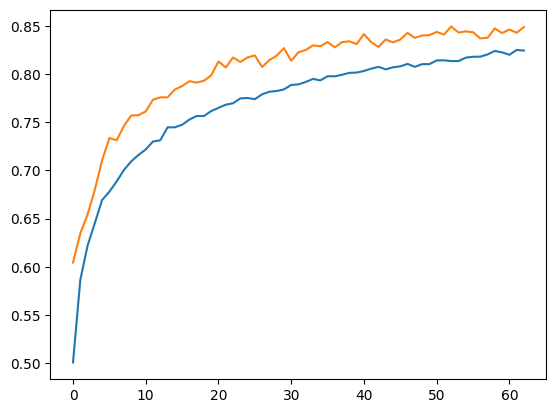

In [20]:
# train과 val의 정확도 비교 그래프
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [34]:
# test데이터 만들기
labelfold='../data/label/'
test_df=json_df_make(['A/','C/','E/','G/'])
test_df

,id,bbox,occluded,num_keypoints,keypoints,action,age,disabled,mask,foldname,json_name,action_int,get_int
0,0,"[578, 181, 802, 695]",1,16,"[692, 663, 2, 671, 559, 2, 659, 448, 2, 733, 4...",stand,adult,0,0,A,[emergency]accident11_087A_0.json,0,2
1,0,"[566, 180, 818, 710]",1,16,"[689, 668, 1, 674, 579, 2, 659, 453, 2, 724, 4...",walk,adult,0,0,A,[emergency]accident11_087A_10.json,1,2
2,0,"[870, 182, 1323, 1063]",1,16,"[969, 1016, 1, 1054, 870, 1, 1025, 700, 1, 112...",stand,adult,0,0,A,[emergency]accident11_087A_100.json,0,2
3,0,"[899, 140, 1299, 1062]",1,16,"[1013, 1024, 1, 1059, 863, 1, 1055, 682, 2, 11...",stand,adult,0,0,A,[emergency]accident11_087A_110.json,0,2
4,0,"[927, 131, 1299, 1060]",1,16,"[1031, 1028, 1, 1097, 848, 1, 1071, 661, 2, 10...",stand,adult,0,0,A,[emergency]accident11_087A_120.json,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,1,"[1256, 385, 1632, 1007]",1,16,"[1459, 931, 2, 1513, 904, 2, 1450, 765, 2, 151...",sit down,adult,0,0,G,[emergency]accident12_056G_60.json,3,2
1452,1,"[1292, 826, 1792, 1079]",1,16,"[1352, 1028, 0, 1460, 1011, 0, 1479, 1078, 0, ...",stand,adult,0,0,G,[emergency]accident12_056G_600.json,0,2
1453,1,"[1256, 385, 1632, 1007]",1,16,"[1459, 931, 2, 1513, 904, 2, 1450, 765, 2, 151...",sit down,adult,0,0,G,[emergency]accident12_056G_70.json,3,2
1454,1,"[1270, 385, 1632, 1006]",1,16,"[1459, 931, 2, 1513, 904, 2, 1450, 765, 2, 151...",sit down,adult,0,0,G,[emergency]accident12_056G_80.json,3,2


In [35]:
a=[]

for i in range(len(test_df)):
    a.append(np.array(test_df.keypoints[i]))

a_a=np.array(a)
a_a.reshape(-1,16,3)

array([[[ 692,  663,    2],
        [ 671,  559,    2],
        [ 659,  448,    2],
        ...,
        [ 752,  282,    2],
        [ 772,  358,    2],
        [ 766,  451,    2]],

       [[ 689,  668,    1],
        [ 674,  579,    2],
        [ 659,  453,    2],
        ...,
        [ 752,  285,    2],
        [ 766,  358,    2],
        [ 747,  436,    2]],

       [[ 969, 1016,    1],
        [1054,  870,    1],
        [1025,  700,    1],
        ...,
        [1167,  360,    1],
        [1181,  483,    1],
        [1184,  536,    2]],

       ...,

       [[1459,  931,    2],
        [1513,  904,    2],
        [1450,  765,    2],
        ...,
        [1490,  506,    2],
        [1517,  596,    1],
        [1512,  675,    1]],

       [[1459,  931,    2],
        [1513,  904,    2],
        [1450,  765,    2],
        ...,
        [1490,  506,    2],
        [1517,  596,    1],
        [1512,  675,    1]],

       [[1459,  931,    2],
        [1513,  904,    2],
        [1450,  

In [36]:
# YOLO로드 => yolo 포맷 및 클래스명 불러오기
net=cv2.dnn.readNet('yolov3.weights','yolov3.cfg') # 네트워크 불러오기
## 1. dnn란 deep neural network로 모듈

# GPU 사용
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

# YOLO에 저장된 클래스 종류
classes=[]
with open('coco.names','r') as f: # coco.names의 파일 안에는 다양한 종류의 클래스가 있음
    classes=[line.strip() for line in f.readlines()]

# YOLO 클래스 확인
print(f'파일에 저장되어 있는 클래스 종류\n {classes}\n 종류의 개수={len(classes)}')

# YOLO의 layer확인
layer_names=net.getLayerNames() # 네트워크의 모든 레이어 이름을 가지고 옴 => conv_0, conv_26 등등
output_layers=[layer_names[i-1] for i in net.getUnconnectedOutLayers()]
## 1. net.getUnconnectedOutLayers() : 출력레이어 가져오기
## 2. i-1부분은 출처에는 i[0]-1라고 되어 있는데 오류가 나오는데 왜 [0]을 해줘야 할까??
## 3. YOLO에눈 3개의 출력 레이어가 있음 => 82/94/106

# 랜덤으로 색 지정하기 => RGB
colors=np.random.uniform(0,255,size=(len(classes),3))
## 1. 80행 3열로 된 0~255인 균일분포의 값을 랜덤 추출

파일에 저장되어 있는 클래스 종류
 ['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
 종류의 개수=80


In [37]:
# 이미지에 바운딩 박스 그려주는 함수
def img_bou(path):
    # 이미지 불러오기
    img=cv2.imread(path)
    img=cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
    # img=cv2.resize(img,(850,850),fx=0.4,fy=0.4)
    height,width,channels=img.shape

    # 객체 탐지
    blob = cv2.dnn.blobFromImage(img, 0.00392, (608, 608), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    # 바운딩 박스 죄표 찾기
    class_ids = []
    confidences = [] 
    boxes = [] 

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if class_id==0 and confidence > 0.5:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
    
    # 노이즈 제거
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    # 화면에 표시
    font = cv2.FONT_HERSHEY_PLAIN
    boxes_index=[] 

    for i in range(len(boxes)):
        if i in indexes:
            boxes_index.append(boxes[i]) 
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            color = colors[i]
            cv2.rectangle(img, (x, y), (x + w, y + h), color, 2) 
            cv2.putText(img, label, (x, y + 30), font, 3, color, 3)

    print(boxes_index)
    plt.imshow(img)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

[[438, 268, 246, 553], [690, 239, 232, 589]]


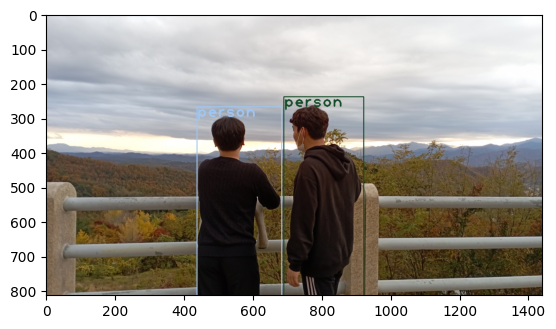

In [38]:
img_bou('busuksa4.jpg')

In [39]:
# test데이터로 예측하기
def test_pre(json_name):
    dect_df=test_df[test_df.json_name==json_name]
    path='C:/Users/USER/Desktop/com_project/data/rawdata/'
    plt.figure(figsize=(20,5))
    s=1
    for i in dect_df.index:
        acc=json_name.split('_')[0]
        sina=json_name.split('_')[1]
        fold=acc+'_'+sina
        plt.subplot(1,len(dect_df),s)
        s+=1
        img_bou(path+sina[-1]+'/'+fold+'/'+json_name.split('.')[0]+'.jpg')
        val=np.array(dect_df.loc[i,'keypoints']).reshape(-1,16,3)
        pre=action_str[np.argmax(history.model.predict(val))]
        print(f"실제값은{dect_df.loc[i,'action']} 예측값은{pre}")

In [42]:
dect_df=test_df[test_df.json_name=='[emergency]accident12_056E_600.json']
dect_df.index

Int64Index([967, 968], dtype='int64')

[[782, 613, 412, 396]]


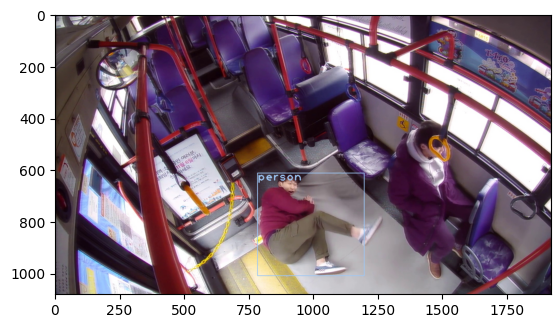

In [43]:
img_bou('C:/Users/USER/Desktop/com_project/data/rawdata/G/[emergency]accident12_056G/[emergency]accident12_056G_230.jpg')

[]
1/1 [==============================] - 0s 18ms/step
실제값은sit down 예측값은sit down
[]
1/1 [==============================] - 0s 16ms/step
실제값은walk 예측값은sit down


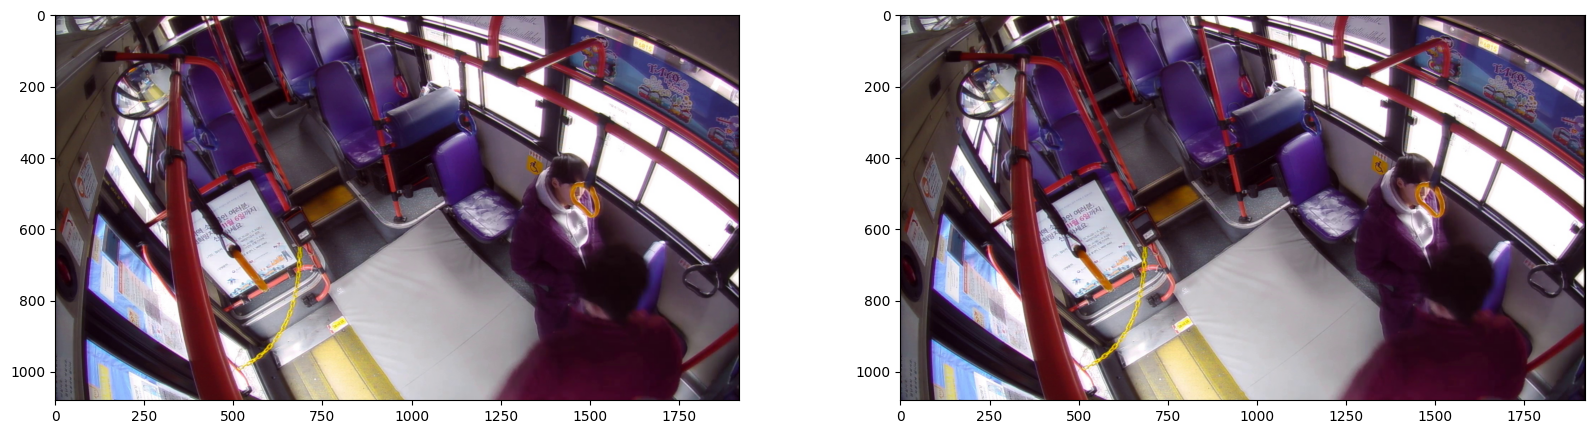

In [46]:
test_pre('[emergency]accident12_056G_190.json')

[[782, 613, 412, 396]]
1/1 [==============================] - 0s 14ms/step
실제값은sit down 예측값은sit down
[[782, 613, 412, 396]]
1/1 [==============================] - 0s 24ms/step
실제값은lay down 예측값은lay down


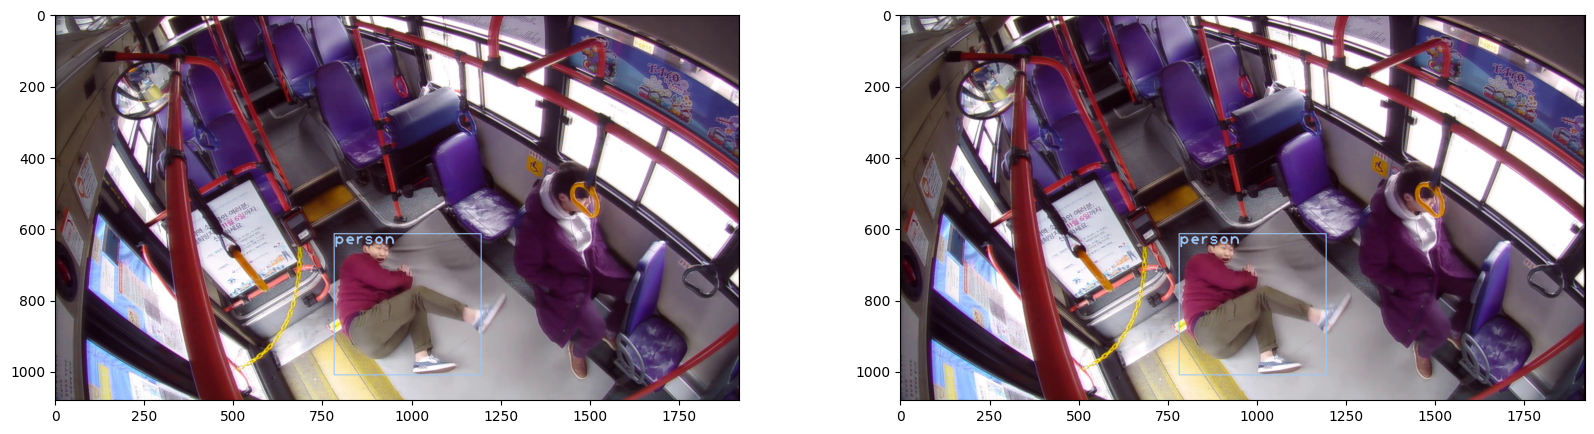

In [45]:
test_pre('[emergency]accident12_056G_230.json')

[[875, 548, 292, 476]]
1/1 [==============================] - 0s 24ms/step
실제값은lay down 예측값은lay down
[[875, 548, 292, 476]]
1/1 [==============================] - 0s 16ms/step
실제값은sit down 예측값은sit down


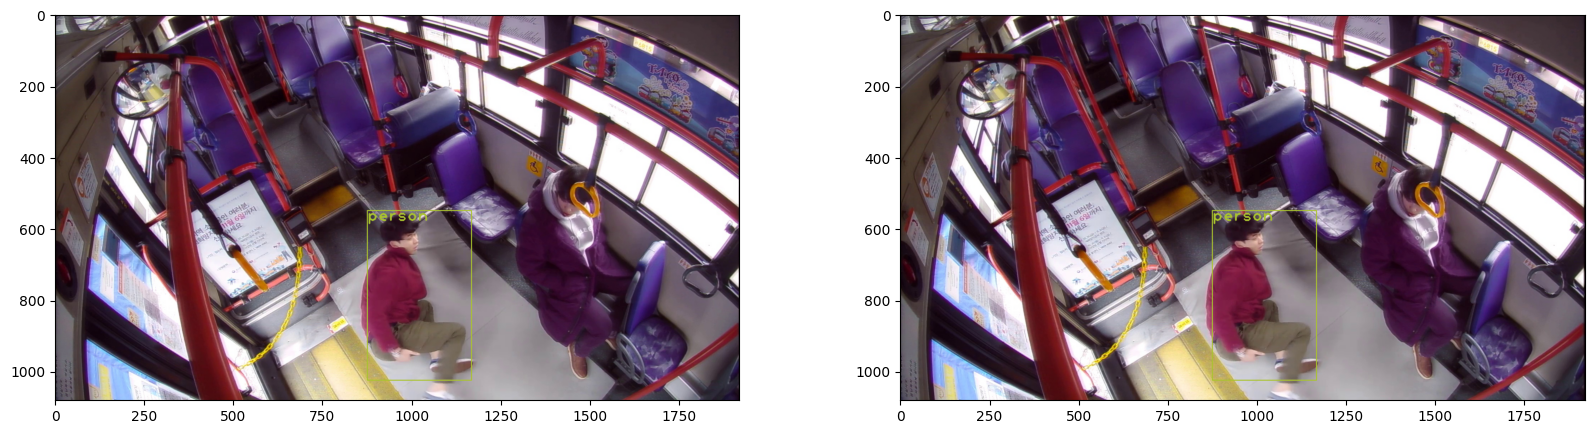

In [47]:
test_pre('[emergency]accident12_056G_250.json')

[[774, 627, 375, 430], [432, 502, 179, 206]]
1/1 [==============================] - 0s 17ms/step
실제값은stand 예측값은stand
[[774, 627, 375, 430], [432, 502, 179, 206]]
1/1 [==============================] - 0s 25ms/step
실제값은stand 예측값은walk


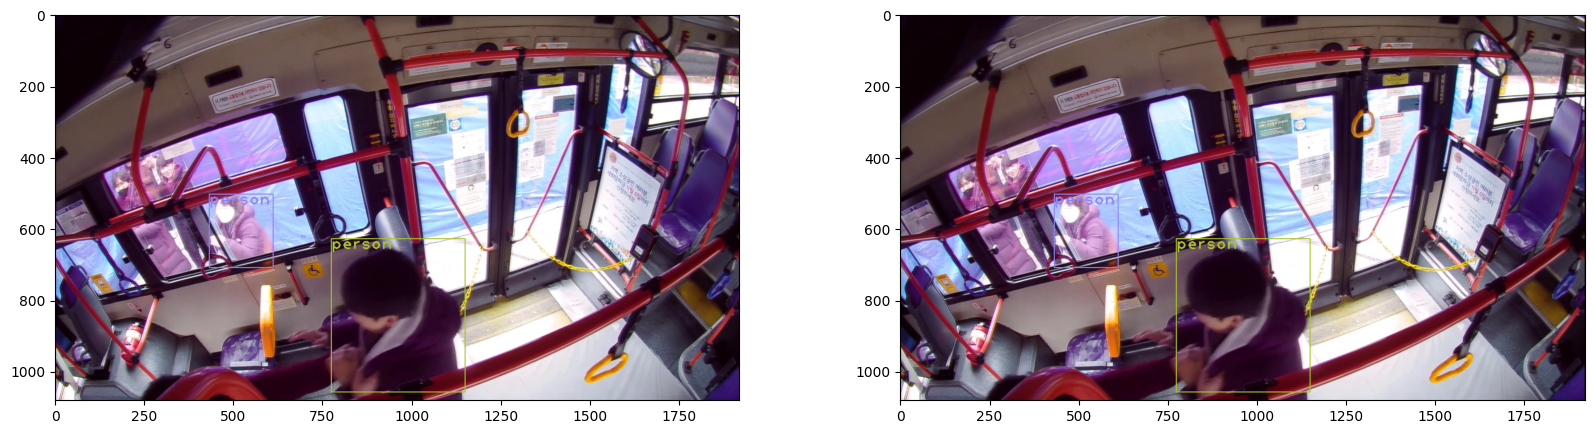

In [48]:
test_pre('[emergency]accident12_056E_610.json')

In [2]:
import cv2
import numpy as np
from proto_file_path import *
from weights_file_path import *
from BODY_PARTS import *
from POSE_PAIRS import *
from yolo_classes import classes

In [62]:
# 바운딩 박스
def yolo(size, score_threshold, nms_threshold):
    # YOLO 네트워크 불러오기
    net = cv2.dnn.readNet("yolov4.weights", "yolov4.cfg")
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

    # GPU 사용
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

    # 클래스의 갯수만큼 랜덤 RGB 배열을 생성
    colors = np.random.uniform(0, 255, size=(len(classes), 3))

    # 이미지의 높이, 너비, 채널 받아오기
    height, width, channels = frame_origin.shape

    # 네트워크에 넣기 위한 전처리
    blob = cv2.dnn.blobFromImage(frame_origin, 0.00392, (size, size), (0, 0, 0), True, crop=False)

    # 전처리된 blob 네트워크에 입력
    net.setInput(blob)

    # 결과 받아오기
    outs = net.forward(output_layers)

    # 각각의 데이터를 저장할 리스트 생성 및 초기화
    class_ids = []
    confidences = []
    boxes = []
    nms_boxes.clear()

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if class_id==0 and confidence > 0.1:
                # 탐지된 객체의 너비, 높이 및 중앙 좌표값 찾기
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                # 객체의 사각형 테두리 중 좌상단 좌표값 찾기
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    print('│' + " YOLO ".center(90, '─') + '│')
    # 후보 박스(x, y, width, height) 출력
    # print(f"│boxes: {boxes}")
    # print(f"│confidences: {confidences}")

    # 노이즈 제거 (Non Maximum Suppression) (겹쳐있는 박스 중 상자가 물체일 확률이 가장 높은 박스만 남겨둠)
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, score_threshold=score_threshold, nms_threshold=nms_threshold)

    # NMS 을 통해 걸러진 박스의 인덱스 출력
    # print(f"│indexes: ", end='')
    # for index in indexes:
    #     print(index, end=' ')
    # print()

    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            class_name = classes[class_ids[i]]

            # 중복된 객체를 이름 뒤 숫자를 추가하여 구분
            class_name += '_1'
            num = 1
            while class_name in nms_boxes.keys():
                num += 1
                class_name = class_name[:-1] + str(num)

            # 프레임에 작성할 텍스트 및 색깔 지정
            label = f"{class_name}: {confidences[i]:.2f}"
            color = colors[class_ids[i]]

            # 프레임에 사각형 테두리 그리기 및 텍스트 쓰기
            cv2.rectangle(frame_drawn, (x, y), (x + w, y + h), color, 2)
            # cv2.rectangle(frame_drawn, (x - 1, y), (x + len(class_name) * 13 + 80, y - 25), color, -1)
            cv2.putText(frame_drawn, label, (x, y - 8), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (255, 255, 255), 2)

            # 탐지된 객체의 정보 출력 및 nms_boxex 에 저장
            print('{0}│'.format(
                f"│ [{class_name}] conf: {confidences[i]} / x: {x} / y: {y} / width: {w} / height: {h}".ljust(91, ' ')))
            nms_boxes[class_name] = [x, y, w, h]

In [63]:
def output_keypoints(proto_file, weights_file, threshold, BODY_PARTS):
    global points

    # 네트워크 불러오기
    net = cv2.dnn.readNetFromCaffe(proto_file, weights_file)

    # GPU 사용
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

    # 입력 이미지의 사이즈 정의
    image_height = 368
    image_width = 368

    # 네트워크에 넣기 위한 전처리
    input_blob = cv2.dnn.blobFromImage(frame_origin, 1.0 / 255, (image_width, image_height), (0, 0, 0),
                                       swapRB=False, crop=False)

    # 전처리된 blob 네트워크에 입력
    net.setInput(input_blob)

    # 결과 받아오기
    out = net.forward()
    # The output is a 4D matrix :
    # The first dimension being the image ID ( in case you pass more than one image to the network ).
    # The second dimension indicates the index of a keypoint.
    # The model produces Confidence Maps and Part Affinity maps which are all concatenated.
    # For COCO model it consists of 57 parts – 18 keypoint confidence Maps + 1 background + 19*2 Part Affinity Maps. Similarly, for MPI, it produces 44 points.
    # We will be using only the first few points which correspond to Keypoints.
    # The third dimension is the height of the output map.
    out_height = out.shape[2]
    # The fourth dimension is the width of the output map.
    out_width = out.shape[3]

    # 원본 이미지의 높이, 너비를 받아오기
    frame_height, frame_width = frame_origin.shape[:2]

    # 포인트 리스트 초기화
    points = []

    print('│' + " POINT ".center(90, '─') + '│')
    for i in range(len(BODY_PARTS)):

        # 신체 부위의 confidence map
        prob_map = out[0, i, :, :]

        # 최소값, 최대값, 최소값 위치, 최대값 위치
        min_val, prob, min_loc, point = cv2.minMaxLoc(prob_map)

        # 원본 이미지에 맞게 포인트 위치 조정
        x = int((frame_width * point[0]) / out_width)
        y = int((frame_height * point[1]) / out_height)

        if prob > threshold:  # [pointed]
            cv2.circle(frame_drawn, (x, y), 5, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
            cv2.putText(frame_drawn, str(i), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 1,
                        lineType=cv2.LINE_AA)

            points.append((x, y))
            print('{0}│'.format(
                f"│ [pointed] {BODY_PARTS[i]} ({i}) => prob: {prob:.5f} / x: {x} / y: {y}".ljust(91, ' ')))

        else:  # [not pointed]
            cv2.circle(frame_drawn, (x, y), 5, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
            cv2.putText(frame_drawn, str(i), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 1,
                        lineType=cv2.LINE_AA)

            points.append(None)
            print('{0}│'.format(
                f"│ [not pointed] {BODY_PARTS[i]} ({i}) => prob: {prob:.5f} / x: {x} / y: {y}".ljust(91, ' ')))

In [64]:
def output_keypoints_with_lines(POSE_PAIRS):
    print('│' + " LINK ".center(90, '─') + '│')
    for pair in POSE_PAIRS:
        part_a = pair[0]  # 0 (Head)
        part_b = pair[1]  # 1 (Neck)
        if points[part_a] and points[part_b]:
            print('{0}│'.format(f"│ [linked] {part_a} {points[part_a]} <=> {part_b} {points[part_b]}".ljust(91, ' ')))
            cv2.line(frame_drawn, points[part_a], points[part_b], (0, 255, 0), 2)
        else:
            print('{0}│'.format(f"│ [not linked] {part_a} {points[part_a]} <=> {part_b} {points[part_b]}".ljust(91, ' ')))

In [65]:
def in_box():
    print('│' + " IN BOX ".center(90, '─') + '│')
    for key, value in nms_boxes.items():
        if key.split('_')[0] != "person":  # person 오브젝트 제외
            points_string = ""
            for index, point in enumerate(points):
                if point is not None and index != 25:  # point 가 없을 경우와 배경일 경우 제외
                    x = value[0]
                    y = value[1]
                    width = value[0] + value[2]
                    height = value[1] + value[3]
                    if (point[0] > x) and (point[0] < width) and (point[1] > y) and (point[1] < height):
                        points_string += str(index) + ' '
            if len(points_string) > 0:
                print('│{0}│'.format((f" [{key}] " + points_string).ljust(90, ' ')))

In [25]:
# 이미지 경로
girl = "busuksa1.jpg" 
man = "busuksa2.jpg"  
man_2 = "busuksa3.jpg" 
woman = "busuksa4.jpg"
images = [girl, man, man_2, woman]

# 키포인트를 저장할 리스트 생성
points = []

# NMS 를 거친 객체 box 들의 정보를 저장할 딕셔너리 생성 (in_box() 함수에서 사용됨)
nms_boxes = {}

# 입력 사이즈 리스트 (Yolo 에서 사용되는 네크워크 입력 이미지 사이즈)
size_list = [320, 416, 608]

for image in images:
    file_name = image.split('\\')[-1]
    text_start = ' ' + file_name + " START "
    text_end = ' ' + file_name + " END"

    print('\n┌' + text_start.center(90, '─') + '┐')
    # 이미지 읽어오기
    frame_origin = cv2.imread(image)  # 네트워크에 넣을 프레임
    frame_drawn = cv2.imread(image)  # 텍스트 및 테두리가 그려질 프레임

    yolo(size=size_list[1], score_threshold=0.4, nms_threshold=0.4)
    output_keypoints(proto_file=protoFile_body_25, weights_file=weightsFile_body_25, threshold=0, BODY_PARTS=BODY_PARTS_MPI)
    output_keypoints_with_lines(POSE_PAIRS=POSE_PAIRS_MPI)
    in_box()
    print('└' + text_end.center(90, '─') + '┘')

    cv2.imshow(file_name, frame_drawn)
    if cv2.waitKey(0) == 27:  # esc 입력시 종료
        break
    cv2.destroyAllWindows()


┌─────────────────────────────────── busuksa1.jpg START ───────────────────────────────────┐
│────────────────────────────────────────── YOLO ──────────────────────────────────────────│
│ [person_1] conf: 0.9839017987251282 / x: 517 / y: 677 / width: 351 / height: 581         │
│ [person_2] conf: 0.9766013622283936 / x: -32 / y: 503 / width: 1113 / height: 942        │
│ [person_3] conf: 0.9947773814201355 / x: 828 / y: 646 / width: 253 / height: 796         │
│───────────────────────────────────────── POINT ──────────────────────────────────────────│
│ [pointed] Head (0) => prob: 0.84508 / x: 657 / y: 657                                    │
│ [pointed] Neck (1) => prob: 0.84387 / x: 962 / y: 782                                    │
│ [pointed] RShoulder (2) => prob: 0.79289 / x: 868 / y: 845                               │
│ [pointed] RElbow (3) => prob: 0.63073 / x: 516 / y: 939                                  │
│ [pointed] RWrist (4) => prob: 0.81501 / x: 633 / y: 845            

In [78]:
# 캠 활성화
cap = cv2.VideoCapture('test.mp4')
# cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640) #카메라 속성 설정
# cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480) # width:너비, height: 높이

# inputWidth=320;
# inputHeight=240;
# inputScale=1.0/255;

if not cap.isOpened:
    print('(!)Error opening video capture')
    exit(0)
while True:
    ret, frame = cap.read()
    
    if frame is None:
        print('(!)No captured frame Break!')
        break
    
    file_name = 'test.mp4'.split('.')[0]
    text_start = ' ' + file_name + " START "
    text_end = ' ' + file_name + " END"

    print('\n┌' + text_start.center(90, '─') + '┐')

    frame_origin = cv2.resize(frame, None, fx=0.8, fy=0.8)  # 네트워크에 넣을 프레임
    frame_drawn = cv2.resize(frame, None, fx=0.8, fy=0.8)  # 텍스트 및 테두리가 그려질 프레임
    
    yolo(size=size_list[1], score_threshold=0.4, nms_threshold=0.4)
    output_keypoints(proto_file=protoFile_body_25, weights_file=weightsFile_body_25, threshold=0, BODY_PARTS=BODY_PARTS_MPI)
    output_keypoints_with_lines(POSE_PAIRS=POSE_PAIRS_MPI)
    in_box()
    print('└' + text_end.center(90, '─') + '┘')
    
    # q 입력시 종료
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    cv2.imshow("YOLO test", frame_drawn)
cv2.destroyAllWindows()


┌─────────────────────────────────────── test START ───────────────────────────────────────┐
│────────────────────────────────────────── YOLO ──────────────────────────────────────────│
│ [person_1] conf: 0.6209605932235718 / x: 593 / y: 438 / width: 66 / height: 135          │
│ [person_2] conf: 0.9151063561439514 / x: 9 / y: 455 / width: 129 / height: 121           │
│ [person_3] conf: 0.7871614694595337 / x: 269 / y: 447 / width: 67 / height: 129          │
│ [person_4] conf: 0.7739222645759583 / x: 328 / y: 459 / width: 59 / height: 117          │
│ [person_5] conf: 0.8619474172592163 / x: 724 / y: 456 / width: 99 / height: 120          │
│ [person_6] conf: 0.8004281520843506 / x: 79 / y: 437 / width: 267 / height: 138          │
│ [person_7] conf: 0.7881037592887878 / x: 366 / y: 401 / width: 301 / height: 174         │
│ [person_8] conf: 0.8864760994911194 / x: 629 / y: 418 / width: 131 / height: 159         │
│───────────────────────────────────────── POINT ────────────────────

In [51]:
POSE_PAIRS

[['Head', 'Neck'],
 ['Neck', 'RShoulder'],
 ['RShoulder', 'RElbow'],
 ['RElbow', 'RWrist'],
 ['Neck', 'LShoulder'],
 ['LShoulder', 'LElbow'],
 ['LElbow', 'LWrist'],
 ['Neck', 'Chest'],
 ['Chest', 'RHip'],
 ['RHip', 'RKnee'],
 ['RKnee', 'RAnkle'],
 ['Chest', 'LHip'],
 ['LHip', 'LKnee'],
 ['LKnee', 'LAnkle']]

In [28]:
import cv2
from pathlib import Path

# MPII에서 각 파트 번호, 선으로 연결될 POSE_PAIRS
BODY_PARTS = { "Head": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
                "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
                "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "Chest": 14,
                "Background": 15 }

POSE_PAIRS = [ ["Head", "Neck"], ["Neck", "RShoulder"], ["RShoulder", "RElbow"],
                ["RElbow", "RWrist"], ["Neck", "LShoulder"], ["LShoulder", "LElbow"],
                ["LElbow", "LWrist"], ["Neck", "Chest"], ["Chest", "RHip"], ["RHip", "RKnee"],
                ["RKnee", "RAnkle"], ["Chest", "LHip"], ["LHip", "LKnee"], ["LKnee", "LAnkle"] ]

# YOLO 네트워크 불러오기
net = cv2.dnn.readNet("yolov4.weights", "yolov4.cfg")
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

# GPU 사용
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

# 클래스의 갯수만큼 랜덤 RGB 배열을 생성
colors = np.random.uniform(0, 255, size=(len(classes), 3))

###카메라랑 연결...?
capture = cv2.VideoCapture(0) #카메라 정보 받아옴
capture.set(cv2.CAP_PROP_FRAME_WIDTH, 640) #카메라 속성 설정
capture.set(cv2.CAP_PROP_FRAME_HEIGHT, 480) # width:너비, height: 높이

inputWidth=320;
inputHeight=240;
inputScale=1.0/255;

 
#반복문을 통해 카메라에서 프레임을 지속적으로 받아옴
while cv2.waitKey(1) <0:  #아무 키나 누르면 끝난다.
    #웹캠으로부터 영상 가져옴
    hasFrame, frame = capture.read()  
    
    #영상이 커서 느리면 사이즈를 줄이자
    #frame=cv2.resize(frame,dsize=(320,240),interpolation=cv2.INTER_AREA)
    
    #웹캠으로부터 영상을 가져올 수 없으면 웹캠 중지
    if not hasFrame:
        cv2.waitKey()
        break

    # 이미지의 높이, 너비, 채널 받아오기
    height, width, channels = frame.shape

    # 네트워크에 넣기 위한 전처리
    blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

    # 전처리된 blob 네트워크에 입력
    net.setInput(blob)

    # 결과 받아오기
    outs = net.forward(output_layers)

    # 각각의 데이터를 저장할 리스트 생성 및 초기화
    class_ids = []
    confidences = []
    boxes = []
    nms_boxes.clear()

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if class_id==0 and confidence > 0.1:
                # 탐지된 객체의 너비, 높이 및 중앙 좌표값 찾기
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                # 객체의 사각형 테두리 중 좌상단 좌표값 찾기
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    # 노이즈 제거 (Non Maximum Suppression) (겹쳐있는 박스 중 상자가 물체일 확률이 가장 높은 박스만 남겨둠)
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, score_threshold=0.4, nms_threshold=0.4)

    boxes_index=[]

    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            class_name = classes[class_ids[i]]

            # 중복된 객체를 이름 뒤 숫자를 추가하여 구분
            class_name += '_1'
            num = 1
            while class_name in nms_boxes.keys():
                num += 1
                class_name = class_name[:-1] + str(num)

            # 프레임에 작성할 텍스트 및 색깔 지정
            label = f"{class_name}: {confidences[i]:.2f}"
            color = colors[class_ids[i]]

            # 프레임에 사각형 테두리 그리기 및 텍스트 쓰기
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            # cv2.rectangle(frame_drawn, (x - 1, y), (x + len(class_name) * 13 + 80, y - 25), color, -1)
            cv2.putText(frame, label, (x, y - 8), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (255, 255, 255), 2)

            # 탐지된 객체의 정보 출력 및 nms_boxex 에 저장
            nms_boxes[class_name] = [x, y, w, h]

        # 각 POSE_PAIRS별로 선 그어줌 (머리 - 목, 목 - 왼쪽어깨, ...)
    for pair in POSE_PAIRS:
        partA = pair[0]             # Head
        partA = BODY_PARTS[partA]   # 0
        partB = pair[1]             # Neck
        partB = BODY_PARTS[partB]   # 1
        
        #partA와 partB 사이에 선을 그어줌 (cv2.line)
        if points[partA] and points[partB]:
            cv2.line(frame, points[partA], points[partB], (0, 255, 0), 2)
    
            
    cv2.imshow("Output-Keypoints",frame)
 
capture.release()  #카메라 장치에서 받아온 메모리 해제
cv2.destroyAllWindows() #모든 윈도우 창 닫음

# # 각 파일 path
# # BASE_DIR=Path(__file__).resolve().parent
# protoFile = "pose_deploy_linevec_faster_4_stages.prototxt"
# weightsFile = "pose_iter_160000.caffemodel"
 
# # 위의 path에 있는 network 모델 불러오기
# net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

# #쿠다 사용 안하면 밑에 이미지 크기를 줄이는게 나을 것이다
# net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA) #벡엔드로 쿠다를 사용하여 속도향상을 꾀한다
# net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA) # 쿠다 디바이스에 계산 요청


# ###카메라랑 연결...?
# capture = cv2.VideoCapture(0) #카메라 정보 받아옴
# capture.set(cv2.CAP_PROP_FRAME_WIDTH, 640) #카메라 속성 설정
# capture.set(cv2.CAP_PROP_FRAME_HEIGHT, 480) # width:너비, height: 높이

# inputWidth=320;
# inputHeight=240;
# inputScale=1.0/255;

 
# #반복문을 통해 카메라에서 프레임을 지속적으로 받아옴
# while cv2.waitKey(1) <0:  #아무 키나 누르면 끝난다.
#     #웹캠으로부터 영상 가져옴
#     hasFrame, frame = capture.read()  
    
#     #영상이 커서 느리면 사이즈를 줄이자
#     #frame=cv2.resize(frame,dsize=(320,240),interpolation=cv2.INTER_AREA)
    
#     #웹캠으로부터 영상을 가져올 수 없으면 웹캠 중지
#     if not hasFrame:
#         cv2.waitKey()
#         break
    
#     # 
#     frameWidth = frame.shape[1]
#     frameHeight = frame.shape[0]
    
#     inpBlob = cv2.dnn.blobFromImage(frame, inputScale, (inputWidth, inputHeight), (0, 0, 0), swapRB=False, crop=False)
    
#     imgb=cv2.dnn.imagesFromBlob(inpBlob)
#     #cv2.imshow("motion",(imgb[0]*255.0).astype(np.uint8))
    
#     # network에 넣어주기
#     net.setInput(inpBlob)

#     # 결과 받아오기
#     output = net.forward()


#     # 키포인트 검출시 이미지에 그려줌
#     points = []
#     for i in range(0,15):
#         # 해당 신체부위 신뢰도 얻음.
#         probMap = output[0, i, :, :]
    
#         # global 최대값 찾기
#         minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)

#         # 원래 이미지에 맞게 점 위치 변경
#         x = (frameWidth * point[0]) / output.shape[3]
#         y = (frameHeight * point[1]) / output.shape[2]

#         # 키포인트 검출한 결과가 0.1보다 크면(검출한곳이 위 BODY_PARTS랑 맞는 부위면) points에 추가, 검출했는데 부위가 없으면 None으로    
#         if prob > 0.1 :    
#             cv2.circle(frame, (int(x), int(y)), 3, (0, 255, 255), thickness=-1, lineType=cv2.FILLED) # circle(그릴곳, 원의 중심, 반지름, 색)
#             cv2.putText(frame, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, lineType=cv2.LINE_AA)
#             points.append((int(x), int(y)))
#         else :
#             points.append(None)
    
    

#     # 각 POSE_PAIRS별로 선 그어줌 (머리 - 목, 목 - 왼쪽어깨, ...)
#     for pair in POSE_PAIRS:
#         partA = pair[0]             # Head
#         partA = BODY_PARTS[partA]   # 0
#         partB = pair[1]             # Neck
#         partB = BODY_PARTS[partB]   # 1
        
#         #partA와 partB 사이에 선을 그어줌 (cv2.line)
#         if points[partA] and points[partB]:
#             cv2.line(frame, points[partA], points[partB], (0, 255, 0), 2)
    
            
#     cv2.imshow("Output-Keypoints",frame)
 
# capture.release()  #카메라 장치에서 받아온 메모리 해제
# cv2.destroyAllWindows() #모든 윈도우 창 닫음